In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from utils.base_models import BaseModels
from utils.numerical_scalers import NumericalScalers
from utils.categorical_encoders import CategoricalEncoders

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### 1. Leer datos

In [2]:
# 1. Leer el dataset
dataset = pd.read_parquet('./data/2_data_preprocesada.parquet')
dataset = dataset.drop(columns=['DF_TYPE'])

# Seleccionar aleatoriamente el 10% de los datos
dataset = dataset.sample(frac=0.1, random_state=42)
print(dataset.shape)
print(dataset['TARGET'].value_counts())

(130560, 14)
TARGET
0    69943
1    60617
Name: count, dtype: int64


### 2. Generar combinaciones de categóricos y numéricos

In [3]:
# 2. Separar TARGET, df_categorical y df_numeric
df_target = dataset['TARGET']
df_categorical = dataset.select_dtypes(include=['object'])
df_numeric = dataset.select_dtypes(include=['float64', 'int64'])

# 3. Eliminar TARGET de df_numeric
df_numeric = df_numeric.drop(columns=['TARGET'])

In [4]:
# 4. Generar las combinaciones de Encoder y Scaler
encoder_methods = ['LabelEncoder', 'OneHotEncoder', 'OrdinalEncoder', 'FrequencyEncoder', 'BinaryEncoder', 'BackwardDifferenceEncoder']
scaler_methods = ['StandardScaler', 'MinMaxScaler', 'MaxAbsScaler', 'RobustScaler', 'Normalizer', 'PowerTransformer']

# 5. Instanciar CategoricalEncoders
categorical = CategoricalEncoders(dataset=df_categorical)
binary_columns, categorical_columns = categorical.get_binary_categorical_columns()

# 6. Instanciar NumericalScalers
numerical = NumericalScalers(dataset=df_numeric)

# 7. Generar todas las combinaciones de Encoder y Scaler
def get_list_data_processed(encoder_methods, scaler_methods):
    combinations = list(itertools.product(encoder_methods, scaler_methods))
    
    i=0
    list_data_processed = []
    for encoder_method, scaler_method in combinations:
        data_encoded = categorical.provider(binary_columns, categorical_columns, method=encoder_method)
        data_scaled = numerical.provider(method=scaler_method)

        processed_data = pd.concat([data_encoded, data_scaled], axis=1)
        list_data_processed.append((f'{encoder_method} - {scaler_method}', processed_data))
        print(f'{str(i).zfill(2)} -> Encoder: {encoder_method} - Scaler: {scaler_method} - Shape: {processed_data.shape}')
        i+=1
    
    return list_data_processed

list_data_processed = get_list_data_processed(encoder_methods, scaler_methods)

00 -> Encoder: LabelEncoder - Scaler: StandardScaler - Shape: (130560, 13)
01 -> Encoder: LabelEncoder - Scaler: MinMaxScaler - Shape: (130560, 13)
02 -> Encoder: LabelEncoder - Scaler: MaxAbsScaler - Shape: (130560, 13)
03 -> Encoder: LabelEncoder - Scaler: RobustScaler - Shape: (130560, 13)
04 -> Encoder: LabelEncoder - Scaler: Normalizer - Shape: (130560, 13)
05 -> Encoder: LabelEncoder - Scaler: PowerTransformer - Shape: (130560, 13)
06 -> Encoder: OneHotEncoder - Scaler: StandardScaler - Shape: (130560, 39)
07 -> Encoder: OneHotEncoder - Scaler: MinMaxScaler - Shape: (130560, 39)
08 -> Encoder: OneHotEncoder - Scaler: MaxAbsScaler - Shape: (130560, 39)
09 -> Encoder: OneHotEncoder - Scaler: RobustScaler - Shape: (130560, 39)
10 -> Encoder: OneHotEncoder - Scaler: Normalizer - Shape: (130560, 39)
11 -> Encoder: OneHotEncoder - Scaler: PowerTransformer - Shape: (130560, 39)
12 -> Encoder: OrdinalEncoder - Scaler: StandardScaler - Shape: (130560, 13)
13 -> Encoder: OrdinalEncoder - S

### 3. Split test y train de cada dataset

In [5]:
# 4. Generar los conjuntos de entrenamiento y prueba
def get_list_split_data(list_data_processed):
    i=0
    list_split_data = []
    for encoded_scaler, data_processed in list_data_processed:
        X = data_processed
        y = df_target
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        list_split_data.append((encoded_scaler, X_train, X_test, y_train, y_test))
        print(f'{str(i).zfill(2)} -> Split Encoded Scaler Method: {encoded_scaler}')
        i+=1

    return list_split_data

list_split_data = get_list_split_data(list_data_processed)

00 -> Split Encoded Scaler Method: LabelEncoder - StandardScaler
01 -> Split Encoded Scaler Method: LabelEncoder - MinMaxScaler
02 -> Split Encoded Scaler Method: LabelEncoder - MaxAbsScaler
03 -> Split Encoded Scaler Method: LabelEncoder - RobustScaler
04 -> Split Encoded Scaler Method: LabelEncoder - Normalizer
05 -> Split Encoded Scaler Method: LabelEncoder - PowerTransformer
06 -> Split Encoded Scaler Method: OneHotEncoder - StandardScaler
07 -> Split Encoded Scaler Method: OneHotEncoder - MinMaxScaler
08 -> Split Encoded Scaler Method: OneHotEncoder - MaxAbsScaler
09 -> Split Encoded Scaler Method: OneHotEncoder - RobustScaler
10 -> Split Encoded Scaler Method: OneHotEncoder - Normalizer
11 -> Split Encoded Scaler Method: OneHotEncoder - PowerTransformer
12 -> Split Encoded Scaler Method: OrdinalEncoder - StandardScaler
13 -> Split Encoded Scaler Method: OrdinalEncoder - MinMaxScaler
14 -> Split Encoded Scaler Method: OrdinalEncoder - MaxAbsScaler
15 -> Split Encoded Scaler Method

### 4. Entrenar con la lista de modelos

In [6]:
# Inicializar BaseModels y definir los nombres de los modelos
base_models = BaseModels()
name_models = ['logistic_regression', 'decision_tree']

# Iterar sobre los conjuntos de datos codificados
i = 0
all_results = []
for encoded_scalar_method, X_train, X_test, y_train, y_test in list_split_data:
    for name in name_models:
        model = base_models.provider(name)
        model.fit(X_train, y_train)
        
        predict_train = model.predict_proba(X_train)[:, 1]
        predict_test = model.predict_proba(X_test)[:, 1]
        predict_test_class = model.predict(X_test)

        train_auc = roc_auc_score(y_train, predict_train)
        test_auc = roc_auc_score(y_test, predict_test)

        all_results.append((encoded_scalar_method, name, train_auc, test_auc, y_test, predict_test, predict_test_class))

        print(f'{str(i).zfill(2)} -> Model: {name}')
        print(f"Encoded Method: {encoded_scalar_method} - AUC on training data with {name}: {train_auc:.3f}")
        print(f"AUC on testing data with {name}: {test_auc:.3f}\n")
        i += 1

00 -> Model: logistic_regression
Encoded Method: LabelEncoder - StandardScaler - AUC on training data with logistic_regression: 0.807
AUC on testing data with logistic_regression: 0.807

01 -> Model: decision_tree
Encoded Method: LabelEncoder - StandardScaler - AUC on training data with decision_tree: 0.988
AUC on testing data with decision_tree: 0.691

02 -> Model: logistic_regression
Encoded Method: LabelEncoder - MinMaxScaler - AUC on training data with logistic_regression: 0.806
AUC on testing data with logistic_regression: 0.806

03 -> Model: decision_tree
Encoded Method: LabelEncoder - MinMaxScaler - AUC on training data with decision_tree: 0.988
AUC on testing data with decision_tree: 0.684

04 -> Model: logistic_regression
Encoded Method: LabelEncoder - MaxAbsScaler - AUC on training data with logistic_regression: 0.806
AUC on testing data with logistic_regression: 0.806

05 -> Model: decision_tree
Encoded Method: LabelEncoder - MaxAbsScaler - AUC on training data with decision

### 5. Graficar resultados

In [7]:
def print_plot_results(all_results, index):
    encoded_scalar_method, name, _, _, y_test, predict_test, predict_test_class = all_results[index]

    conf_matrix = confusion_matrix(y_test, predict_test_class)
    class_report = classification_report(y_test, predict_test_class)
    auc_score = roc_auc_score(y_test, predict_test)
    accuracy = accuracy_score(y_test, predict_test_class)
    gini_score = 2 * auc_score - 1

    # Print metrics and classification report
    print(f"Model: {name} - Encoded Scalar method {encoded_scalar_method}")
    print(f"AUC Score:\t{auc_score:.3f}")
    print(f"Gini Score:\t{gini_score:.3f}")
    print(f"Accuracy:\t{accuracy:.3f}")
    print(f"Classification Report:\n{class_report}")

    # Crear subplots 1x2
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))

    # Plot confusion matrix with absolute values
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False, ax=ax[0])
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')
    ax[0].set_title('Absolute Values')

    # Plot confusion matrix with percentages
    conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap='Blues', cbar=False, ax=ax[1])
    ax[1].set_xlabel('Predicted Label')
    ax[1].set_ylabel('True Label')
    ax[1].set_title('Percentages')

    # Mostrar los gráficos
    plt.tight_layout()
    plt.show()

Model: decision_tree - Encoded Scalar method LabelEncoder - StandardScaler
AUC Score:	0.691
Gini Score:	0.381
Accuracy:	0.714
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.75     13989
           1       0.72      0.64      0.67     12123

    accuracy                           0.71     26112
   macro avg       0.71      0.71      0.71     26112
weighted avg       0.71      0.71      0.71     26112



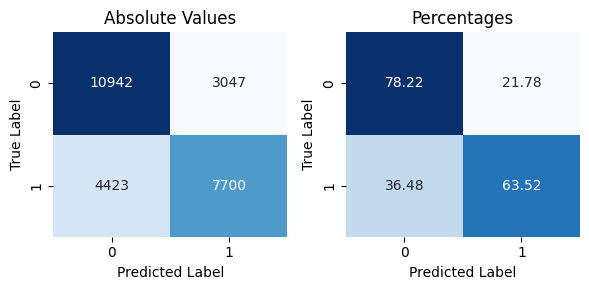

In [8]:
print_plot_results(all_results, 1)

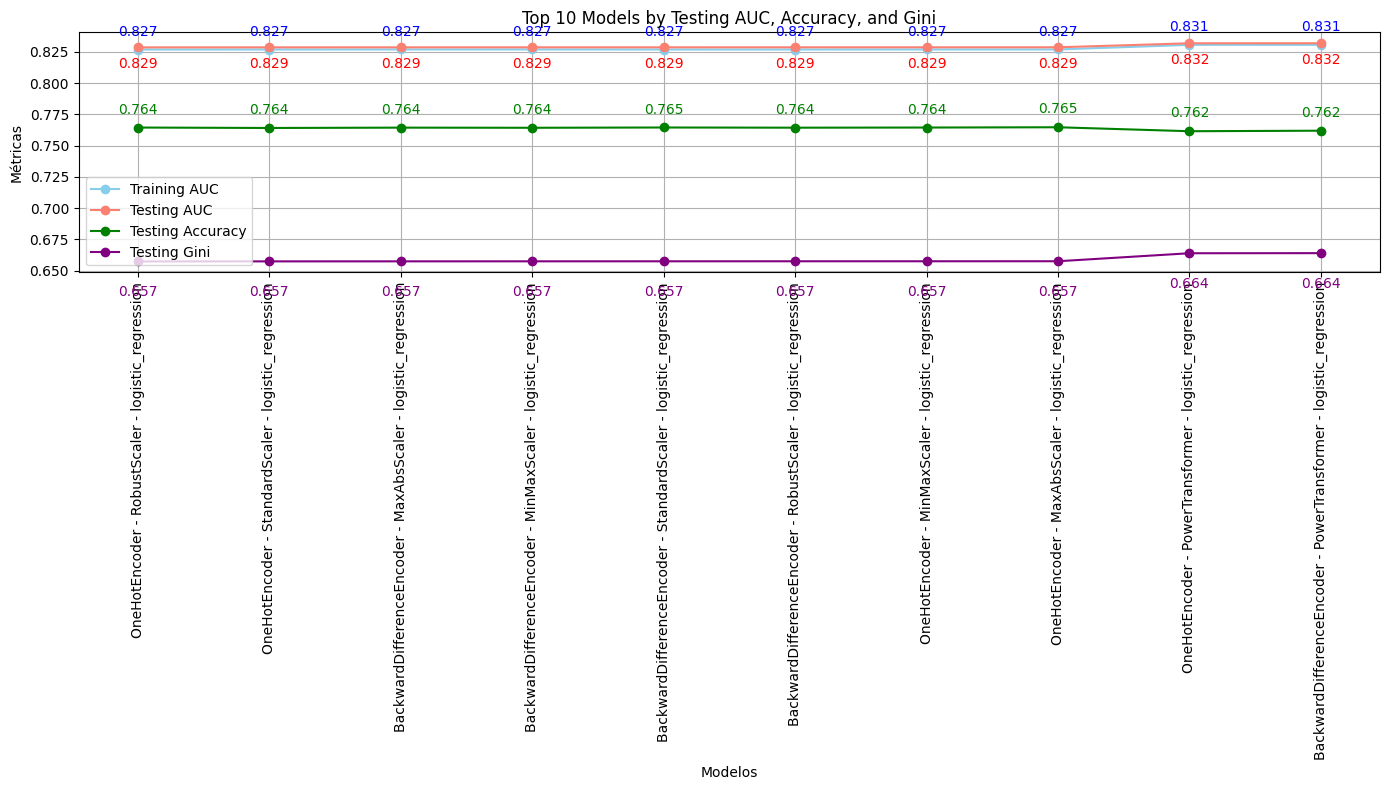

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score

# Consolidar todos los resultados en una lista
consolidated_results = []
for encoded_scalar_method, name, train_auc, test_auc, y_test, predict_test, predict_test_class in all_results:
    full_model_name = f"{encoded_scalar_method} - {name}"
    test_accuracy = accuracy_score(y_test, predict_test_class)
    gini_score = 2 * test_auc - 1
    consolidated_results.append((full_model_name, train_auc, test_auc, test_accuracy, gini_score))

# Ordenar los resultados por test_auc de mayor a menor y seleccionar el top 10
consolidated_results.sort(key=lambda x: x[2], reverse=False)
top_10_results = consolidated_results[-10:]

# Desempaquetar los resultados del top 10
top_10_names, top_10_train_aucs, top_10_test_aucs, top_10_accuracies, top_10_ginis = zip(*top_10_results)

plt.figure(figsize=(14, 8))

# Gráfico de líneas para el top 10
plt.plot(top_10_names, top_10_train_aucs, label='Training AUC', marker='o', color='skyblue')
plt.plot(top_10_names, top_10_test_aucs, label='Testing AUC', marker='o', color='salmon')
plt.plot(top_10_names, top_10_accuracies, label='Testing Accuracy', marker='o', color='green')
plt.plot(top_10_names, top_10_ginis, label='Testing Gini', marker='o', color='purple')

# Añadir los valores a los puntos
for i, txt in enumerate(top_10_train_aucs):
    plt.annotate(f'{txt:.3f}', (top_10_names[i], top_10_train_aucs[i]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
for i, txt in enumerate(top_10_test_aucs):
    plt.annotate(f'{txt:.3f}', (top_10_names[i], top_10_test_aucs[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='red')
for i, txt in enumerate(top_10_accuracies):
    plt.annotate(f'{txt:.3f}', (top_10_names[i], top_10_accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center', color='green')
for i, txt in enumerate(top_10_ginis):
    plt.annotate(f'{txt:.3f}', (top_10_names[i], top_10_ginis[i]), textcoords="offset points", xytext=(0,-25), ha='center', color='purple')

plt.xlabel('Modelos')
plt.ylabel('Métricas')
plt.title('Top 10 Models by Testing AUC, Accuracy, and Gini')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
